# Recurrent Neural Networks in Tensorflow

We use recurrent neural networks (RNNs) to process sequential data. That could be a video (stream of frames), a multi-variate time-series of sensor data, or sequences of symbols such as sentences in a natural language.

Similarly to how we share weights across a spatial feature map in convolutions, RNNs also share weights, but across time and not necessarily across space (unless we construct a convolutional RNN).

Let's assume we have a time-series of 10 features (e.g. **10 sensors**) and the sensors measured at **28 times**. The sequence data for this measurement has the shape **(28, 10)** without a batch dimension, and **(1, 28, 10)** with the batch dimension added (which is always needed).

If our sequential data were videos (or a collection of frames), a batch would have the shape (batch_size, t, h, w, channels). The time dimension is generally in the second axis.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [4]:
# create some dummy data (ANNs can fit to random noise very well!)

# dataset size: 1024; sequence length: 28; features: 10
x_train = np.random.normal(size=(1024, 28, 10))
# target: 0 or 1, randomly assigned
y_train = np.random.randint(low=0, high=2, size=(1024,1))
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

x_val = np.random.normal(size=(512, 28, 10))
# target: 0 or 1, randomly assigned
y_val = np.random.randint(low=0, high=2, size=(512,1))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(512).prefetch(tf.data.AUTOTUNE)

A simple RNN could look something like this: $$f(f(f(f(s_0)+s_1)+s_2)+s_3) ...,$$ where f could be a Dense layer, and $s_t$ is the feature vector in our sequence at time-point t.

This looks just like a feedforward model, except we add new features from the data sequence, and we re-use the same layer over and over again, for all time-steps of processing.

## Unrolled RNNs

One way to implement an RNN based on this understanding is to construct an "unrolled" network for a fixed sequence length, just like we would code a feed-forward model. The only difference is that slices of the model input are added at different parts in the forward computation.

In [ ]:
class UnrolledRNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.layer=tf.keras.layers.Dense(10, activation="tanh")
        
        self.output_layer = tf.keras.layers.Dense(1, activation="sigmoid")
        ...
    def call(self, sequence, training=False):
        # t=0
        layer_state_t0 = self.layer(sequence[:,0,:] + tf.zeros_like(sequence[:,0,:]))
        layer_state_t1 = self.layer(layer_state_t0 + sequence[:,1,:])
        layer_state_t2 = self.layer(layer_state_t1 + sequence[:,2,:])
        layer_state_t3 = self.layer(layer_state_t2 + sequence[:,3,:])
        
        return self.output_layer(layer_state_t3)
    ...

This approach at building an RNN is very useful and allows for fine-grained control over what is happening when in the computational graph. One downside is that we need to determine how long the sequences are. It also assumes that we get the full sequence as input at once and not incrementally. In cases where we want an RNN to control an agent (e.g. a car) in an environment, we need to have a more dynamic RNN that can maintain its state across multiple calls. 

For this we can write a for loop and write the state of the layer to a model attribute after each time-step. Since tensorflow is rather picky about stateful operations, it is highly recommended to not write the for loop yourself, and instead use in-built tensorflow/keras abstractions:

We define an RNN "cell" layer that defines the computations that we want our RNN to apply at every time-step as we loop over the sequence, updating the RNN state.

This **RNN-cell layer** needs to have a **state_size** property, an **output_size** property, and a **get_initial_state** method.

Below I define a somewhat more advanced RNN Cell layer that has two layers , using linear projections (dense layers), orthogonally initialized weight matrices, "layer normalization" layers 

In [5]:
class RNNCell(tf.keras.layers.AbstractRNNCell):

    def __init__(self, recurrent_units_1, recurrent_units_2, **kwargs):
        super().__init__(**kwargs)

        self.recurrent_units_1 = recurrent_units_1
        self.recurrent_units_2 = recurrent_units_2
        
        self.linear_1 = tf.keras.layers.Dense(recurrent_units_1)
        self.linear_2 = tf.keras.layers.Dense(recurrent_units_2)
        
        # first recurrent layer in the RNN
        self.recurrent_layer_1 = tf.keras.layers.Dense(recurrent_units_1, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None),
                                                       activation=tf.nn.tanh)
        # layer normalization for trainability
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        
        # second recurrent layer in the RNN
        self.recurrent_layer_2 = tf.keras.layers.Dense(recurrent_units_2, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None), 
                                                       activation=tf.nn.tanh)
        # layer normalization for trainability
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
    
    @property
    def state_size(self):
        return [tf.TensorShape([self.recurrent_units_1]), 
                tf.TensorShape([self.recurrent_units_2])]
    @property
    def output_size(self):
        return [tf.TensorShape([self.recurrent_units_2])]
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros([self.recurrent_units_1]), 
                tf.zeros([self.recurrent_units_2])]

    def call(self, inputs, states):
        # unpack the states
        state_layer_1 = states[0]
        state_layer_2 = states[1]
        
        # linearly project input
        x = self.linear_1(inputs) + state_layer_1
        
        # apply first recurrent kernel
        new_state_layer_1 = self.recurrent_layer_1(x)
        
        # apply layer norm
        x = self.layer_norm_1(new_state_layer_1)
        
        # linearly project output of layer norm
        x = self.linear_2(x) + state_layer_2
        
        # apply second recurrent layer
        new_state_layer_2 = self.recurrent_layer_2(x)
        
        # apply second layer's layer norm
        x = self.layer_norm_2(new_state_layer_2)
        
        # return output and the list of new states of the layers
        return x, [new_state_layer_1, new_state_layer_2]
    
    def get_config(self):
        return {"recurrent_units_1": self.recurrent_units_1, 
                "recurrent_units_2": self.recurrent_units_2}

### Using the RNN layer in a model

In this example, I use the model.compile and model.fit methods. For this reason, unlike before, we do not specify the optimizer and loss function in the model's constructor method. 

The compile method adds an optimizer to the model, as well as a loss function. As a consequence, the train_step and test_step methods look (only marginally) different from what you've seen before.

In [6]:
class RNNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.rnn_cell = RNNCell(recurrent_units_1=24,
                                recurrent_units_2=48)
        
        # return_sequences collects and returns the output of the rnn_cell for all time-steps
        # unroll unrolls the network for speed (at the cost of memory)
        self.rnn_layer = tf.keras.layers.RNN(self.rnn_cell, return_sequences=False, unroll=True)
        
        self.output_layer = tf.keras.layers.Dense(1, activation="sigmoid")
        
        self.metrics_list = [tf.keras.metrics.Mean(name="loss"),
                             tf.keras.metrics.BinaryAccuracy()]
    
    @property
    def metrics(self):
        return self.metrics_list
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
        
    def call(self, sequence, training=False):
        
        rnn_output = self.rnn_layer(sequence)
        
        return self.output_layer(rnn_output)
    
    def train_step(self, data):
        
        """
        Standard train_step method, assuming we use model.compile(optimizer, loss, ...)
        """
        
        sequence, label = data
        with tf.GradientTape() as tape:
            output = self(sequence, training=True)
            loss = self.compiled_loss(label, output, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)
        
        return {m.name : m.result() for m in self.metrics}
    
    def test_step(self, data):
        
        """
        Standard test_step method, assuming we use model.compile(optimizer, loss, ...)
        """
        
        sequence, label = data
        output = self(sequence, training=False)
        loss = self.compiled_loss(label, output, regularization_losses=self.losses)
                
        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)
        
        return {m.name : m.result() for m in self.metrics}

### Instantiating the model and calling the compile method
In the compile method, we need to specify the optimizer and the loss object. Importantly, we need to pass an instance of the optimizer and the loss, not the class (i.e. tf.keras.losses.BinaryCrossentropy() and not tf.keras.losses.BinaryCrossentropy)

In [7]:
model = RNNModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.BinaryCrossentropy()

# compile the model (here, adding a loss function and an optimizer)
model.compile(optimizer = optimizer, loss=loss)

# Using the fit method to train the RNN model on random noise sequences

So far we used custom training loop functions to train our model. With the model.fit abstraction, we can skip this step. Any custom non-standard behavior that we want to integrate can be implemented with callbacks (tf.keras.callbacks). These can be called after every batch, before every batch, before every epoch, or after every epoch, and you can write your own callbacks that reduce certain hyperparameters over time as training progresses.

Here we want to log all keras metrics of our model to the tensorboard, just like we did before. For this, we use the TensorBoard callback, for which we need to specify the log directory filepath.

We might also want to save our model weights every n epochs, so we can continue training (e.g. if gradients explode and weights become nan values) or we want to analyze what our model learned during a particular phase of training later. There is a callback for checkpointing: tf.keras.callbacks.ModelCheckpoint

In [8]:
EXPERIMENT_NAME = "RNN_noise"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{EXPERIMENT_NAME}/{current_time}")

In [9]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    initial_epoch=25,
                    epochs=50,
                    callbacks=[logging_callback])

Epoch 1/25


2022-12-05 01:31:41.141403: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



 1/32 [..............................] - ETA: 2:40 - loss: 0.7567 - binary_accuracy: 0.4062

2022-12-05 01:31:41.528663: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


32/32 [==============================] - 7s 54ms/step - loss: 0.7741 - binary_accuracy: 0.4922 - val_loss: 0.7497 - val_binary_accuracy: 0.4785
Epoch 2/25
32/32 [==============================] - 0s 14ms/step - loss: 0.6777 - binary_accuracy: 0.5693 - val_loss: 0.7376 - val_binary_accuracy: 0.4863
Epoch 3/25
32/32 [==============================] - 1s 16ms/step - loss: 0.6429 - binary_accuracy: 0.6211 - val_loss: 0.7467 - val_binary_accuracy: 0.4727
Epoch 4/25
32/32 [==============================] - 0s 15ms/step - loss: 0.6180 - binary_accuracy: 0.6641 - val_loss: 0.7502 - val_binary_accuracy: 0.4668
Epoch 5/25
32/32 [==============================] - 1s 17ms/step - loss: 0.5928 - binary_accuracy: 0.7100 - val_loss: 0.7447 - val_binary_accuracy: 0.4746
Epoch 6/25
32/32 [==============================] - 1s 17ms/step - loss: 0.5717 - binary_accuracy: 0.7266 - val_loss: 0.7496 - val_binary_accuracy: 0.4922
Epoch 7/25
32/32 [==============================] - 1s 17ms/step - loss: 0.5501 -

In [10]:
# save the complete model (incl. optimizer state, loss function, metrics etc.)
# ideally save to google drive if you're using colab
model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [11]:
# load the model and resume training where we had to stop
loaded_model = tf.keras.models.load_model("saved_model", custom_objects={"RNNCell": RNNCell,
                                                                         "RNNModel": RNNModel})

## Plot the results

Since we used the logging callback, we can also visualize our data on the tensorboard. The model.fit method however provides us with a history object, containing a dictionary with the metrics across all epochs. 

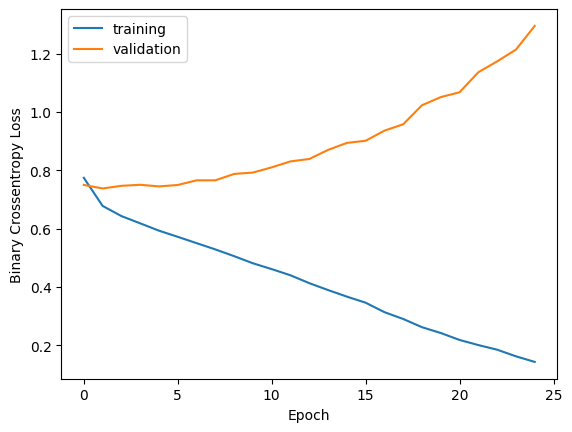

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels=["training","validation"])
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy Loss")
plt.show()

In [ ]:
# look at tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir="logs/RNN_noise"